# Group Project - Social Media Analysis

Author: Yuwei Zhu

In [1]:
# import module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import os
import re
import spacy
import preprocessor as p
import warnings
warnings.filterwarnings("ignore")

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from collections import Counter
from operator import itemgetter
from sklearn.decomposition import LatentDirichletAllocation

import networkx as nx

In [2]:
# load data
df = pd.DataFrame()
path = 'data/'
file_lst = os.listdir(path)
for i in file_lst:
    data = pd.read_excel(os.path.join('data/'+ i),index_col = None)
    df = df.append(data)

In [3]:
df.to_pickle('data_all.pkl')

# Data preprocessing

In [4]:
## Memory Reducer                                     
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
# drop columns with too many NaNs
def drop_nan_column(threshold, df):
    new_df = df.copy()
    total = len(df)
    for column in df:
        percent = df[column].isnull().sum()/total
        if percent > threshold:
            new_df = new_df.drop(columns = [column])
    return new_df

In [6]:
# drop duplicate rows
df = df.drop_duplicates()

In [6]:
len(df)

511269

In [7]:
# drop rows with empty text
data.drop(data[data['Sound Bite Text'].isnull()].index, inplace = True)

In [8]:
len(df)

511269

In [9]:
# check df columns types
for col in df.columns:
    print('{0:15s} data type is: {1:10s}'.format(str(col), str(df[col].dtype)))

Post ID         data type is: object    
Sound Bite Text data type is: object    
Ratings and Scores data type is: float64   
Title           data type is: object    
Source Type     data type is: object    
Post Type       data type is: object    
Media Type      data type is: object    
URL             data type is: object    
Domain          data type is: object    
Published Date (GMT-04:00) New York data type is: object    
Author Gender   data type is: object    
Author URL      data type is: object    
Author Name     data type is: object    
Author Handle   data type is: object    
Author ID       data type is: object    
Author Location - Country 1 data type is: object    
Author Location - State/Province 1 data type is: object    
Author Location - City 1 data type is: object    
Author Location - Country 2 data type is: object    
Author Location - State/Province 2 data type is: object    
Author Location - City 2 data type is: object    
Author Location - Other data type is

In [8]:
# convert date column to type datetime
df['Published Date (GMT-04:00) New York'] = pd.to_datetime(df['Published Date (GMT-04:00) New York'])

In [9]:
# drop rows with review text deleted
df.drop(df[(df["Sound Bite Text"] == "Post deleted by the author.")].index, inplace = True)

In [12]:
df.shape

(327231, 41)

In [10]:
# reduce memory
df = reduce_mem_usage(df)

Mem. usage decreased to 93.62 Mb (10.7% reduction)


In [14]:
df.head(3).transpose()

,0,1,2
Post ID,http://www.cnet.com/news/harrison-ford-drinks-...,18244424300214682891,4d3a787535.441983
Sound Bite Text,"So out came the Bruichladdich , a fine scotch ...",Iphone X Gsmarena Specs and Price: The Iphone ...,com All products are 100% Original. No Refurbi...
Ratings and Scores,NaN,NaN,NaN
Title,"Harrison Ford drinks scotch, tells jokes with ...",Iphone X Gsmarena Specs and Price,"Buy Apple iPhone X 256GB New Space Gray $1,249"
Source Type,Blogs,Blogs,Forums
Post Type,Original,Original,Original
Media Type,No Media,No Media,No Media
URL,http://www.cnet.com/news/harrison-ford-drinks-...,http://www.techlass.com/2017/09/iphone-x-gsmar...,http://www.marineengine.com/boat-forum/showthr...
Domain,cnet.com,techlass.com,marineengine.com
Published Date (GMT-04:00) New York,2017-09-29 05:06:00,2017-09-28 03:35:00,2017-09-28 13:53:00


In [15]:
df.describe()

,Ratings and Scores,No. of Followers/Daily Unique Visitors,Richness,Tags,Total Engagements,Post Comments,Post Likes,Post Shares,Post Views,Post Dislikes,Product Hierarchy,Rating
count,0.0,3.272290e+05,327229.0,0.0,33208.000000,19385.0,31796.000000,709.0,0.0,0.0,0.0,1386.000000
mean,NaN,5.489109e+04,NaN,NaN,364.938385,inf,368.631378,inf,NaN,NaN,NaN,3.607422
std,NaN,1.487094e+06,0.0,NaN,2485.772461,inf,2450.351318,inf,NaN,NaN,NaN,1.420898
min,NaN,0.000000e+00,0.0,NaN,1.000000,1.0,1.000000,1.0,NaN,NaN,NaN,0.000000
25%,NaN,0.000000e+00,1.0,NaN,9.000000,1.0,10.000000,4.0,NaN,NaN,NaN,3.000000
50%,NaN,0.000000e+00,1.0,NaN,28.000000,3.0,28.500000,12.0,NaN,NaN,NaN,4.000000
75%,NaN,0.000000e+00,2.0,NaN,78.000000,6.0,79.000000,43.0,NaN,NaN,NaN,5.000000
max,NaN,1.277749e+08,12.0,NaN,172094.000000,11224.0,158629.000000,12728.0,NaN,NaN,NaN,5.000000


# EDA

## Post Profile 
### Number of post in each day

In [11]:
# date
df['date_day'] = df['Published Date (GMT-04:00) New York'].dt.date

/Users/zhuyuwei/Library/Python/3.7/lib/python/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


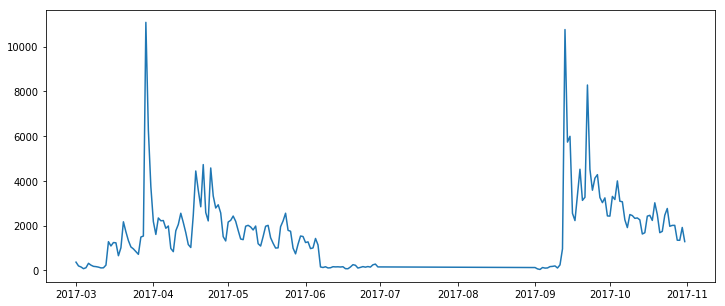

In [12]:
plt.rcParams["figure.figsize"] = (12,5)
plt.plot(df.groupby(['date_day'])['Post ID'].count())

The peak number of post for both product were close. However, iPhone 8 and X had an additional posting peak within 10 days. Also, the following discussion about iPhone on social media looks more intenvise than Samsung Galaxy S8.

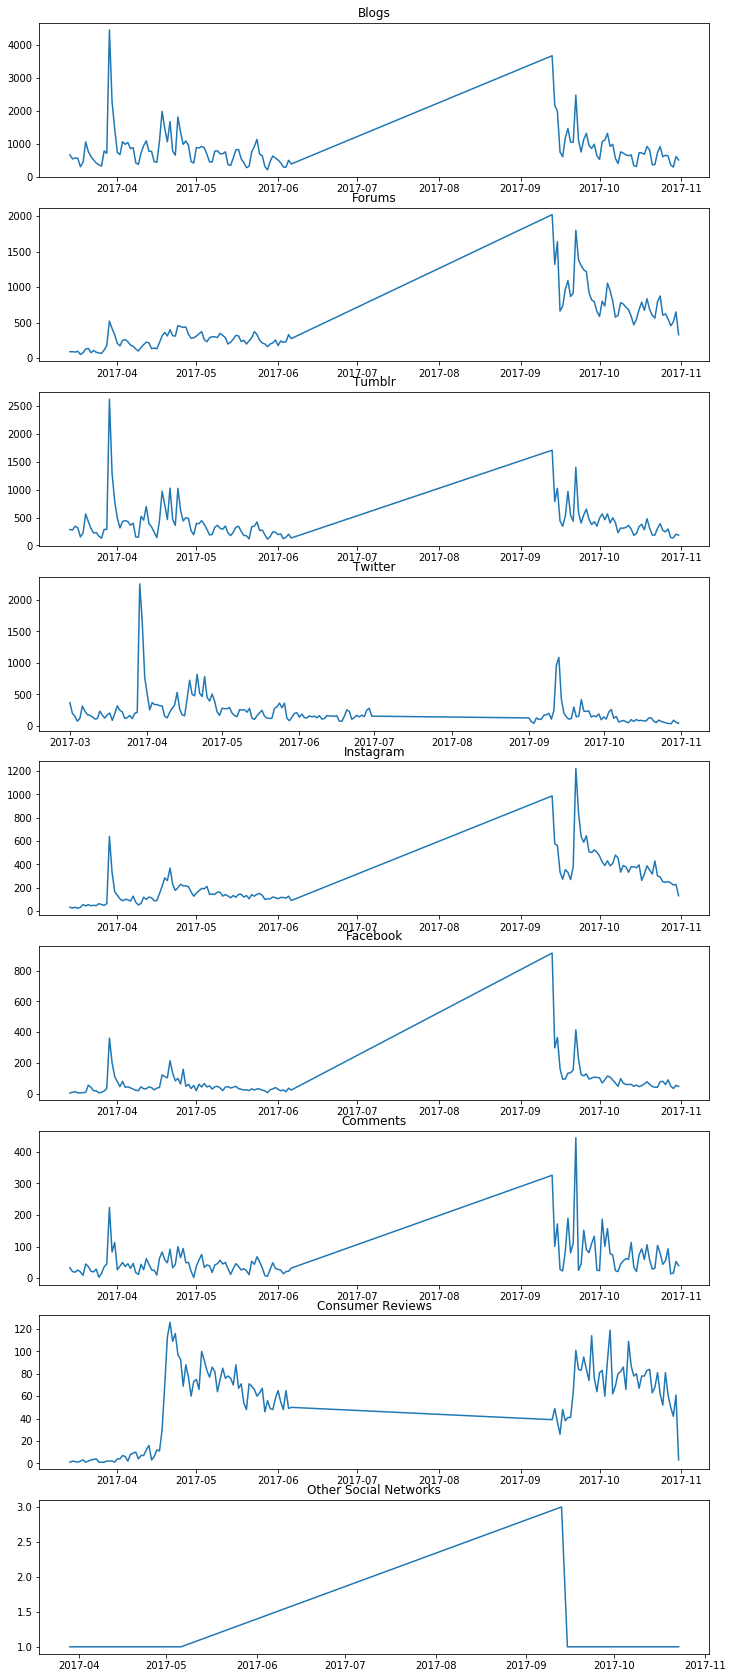

In [14]:
# seperate by source
plt.rcParams["figure.figsize"] = (12,30)
sources = df['Source Type'].value_counts()
for i in range(1,10):
    plt.subplot(9,1,i)
    source_data = df.loc[df['Source Type'] == str(sources.index[i-1])]
    plt.title(str(sources.index[i-1]))
    plt.plot(source_data.groupby(['date_day'])['Post ID'].count())

User posts and comments on different sources are not totally simultaneously. When Samsung Galaxy S8 released, twitter and consumer reviews response later than other social media. However, when iPhone 8 and iPhone X released, all the other sources excepts consumer reviews response in relatively same time.

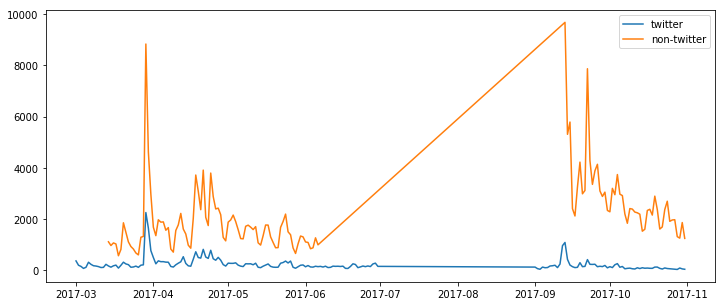

In [15]:
# twitter vs. non-twitter
plt.rcParams["figure.figsize"] = (12,5)
twitter = df.loc[df['Source Type'] == 'Twitter']
non_twitter = df.loc[df['Source Type'] != 'Twitter']
labels = ['twitter', 'non-twitter']

plt.plot(twitter.groupby(['date_day'])['Post ID'].count())
plt.plot(non_twitter.groupby(['date_day'])['Post ID'].count())
plt.legend(labels)

When samsung Galaxy S8 released, twitter and non-twitter responses similar. However, users on twitter response were not so overwhelming comparing to other sources.

## Top users

In [16]:
followers = df.groupby('Post ID').agg({'No. of Followers/Daily Unique Visitors': 'max'})
followers = followers.loc[followers['No. of Followers/Daily Unique Visitors'] > 10]
count = followers['No. of Followers/Daily Unique Visitors'].value_counts().tolist()
follower_number = followers['No. of Followers/Daily Unique Visitors'].value_counts().index.tolist()

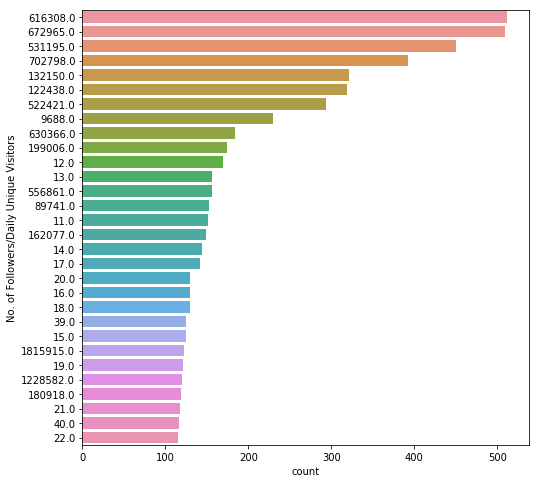

In [17]:
plt.figure(figsize = (8,8))
sns.countplot(y = followers["No. of Followers/Daily Unique Visitors"], \
              order = followers["No. of Followers/Daily Unique Visitors"].value_counts().index[:30])
plt.show()

In [18]:
# top 10 user
followers.reset_index().sort_values(by = 'No. of Followers/Daily Unique Visitors', ascending = False).head(10)

,Post ID,No. of Followers/Daily Unique Visitors
116,104753296264554_1477511468988723,127774880.0
117,104753296264554_1478921125514424,127774880.0
176,107593572595009_1453195688034784_1466950189992667,116854496.0
779,133803174373_10155328236859374_10155335472539374,116854496.0
197,107593572595009_1514091941945158_1515324875155198,116854496.0
198,107593572595009_1514091941945158_1515344831819869,116854496.0
199,107593572595009_1514091941945158_1515347155152970,116854496.0
200,107593572595009_1518759574811728,116854496.0
201,107593572595009_1674975705856780,116854496.0
774,133803174373_10155322839224374_10155335472344374,116854496.0


## Correlation

In [23]:
# drop nan columns
drop_nan = drop_nan_column(0.95, df)

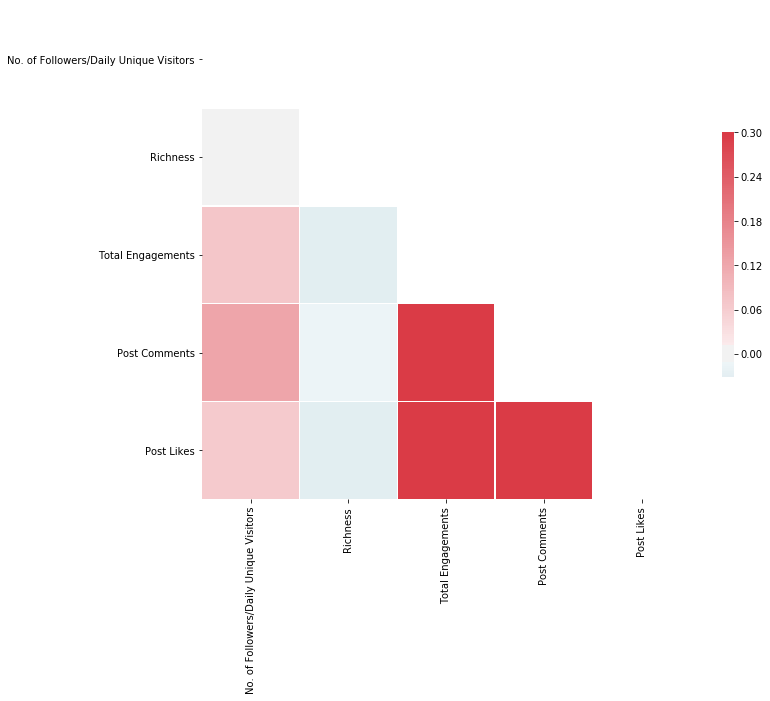

In [24]:
correlation_matrix = drop_nan.corr()
mask = np.zeros_like(correlation_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Feature Extraction

In [19]:
# drop replies and comments, only keep the original post
nlp_data = df.loc[df['Post Type'] == 'Original'].reset_index()[['Sound Bite Text']]

In [91]:
nlp_data['original_text'] = df.loc[df['Post Type'] == 'Original'].reset_index()[['Sound Bite Text']]

In [20]:
nlp = spacy.load('en_core_web_sm', disable = ['ner', 'parser'], max_length = 1000000000)

In [21]:
nlp_data = nlp_data.fillna('')

In [22]:
def clean_data(df):
    text = df
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', text)
    
    #Convert to lowercase
    text = text.lower()
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
   
    return text

In [23]:
nlp_data['Sound Bite Text'] = nlp_data['Sound Bite Text'].apply(clean_data)

In [24]:
# remove url, hastag, etc.
# using twitter preprocessor package
nlp_data['Sound Bite Text'] = nlp_data['Sound Bite Text'].apply(lambda x: p.clean(x))

In [25]:
# tokenize
nlp_data['clean_text'] = nlp_data['Sound Bite Text'].apply(lambda x: nlp.tokenizer(x))

In [26]:
# split product
def conditions(df):
    if ('iphone' in df['Sound Bite Text']):
        product = 'iPhone'
        return product
    if ('galaxy' in df['Sound Bite Text']):
        product = 'Galaxy'
        return product
    else:
        product = 'not known'
        return product

In [27]:
nlp_data['product'] = nlp_data.apply(conditions, axis = 1)

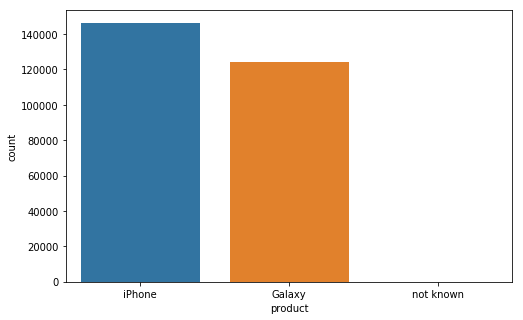

In [28]:
plt.figure(figsize = (8,5))
sns.countplot(nlp_data['product'], order = nlp_data['product'].value_counts().index)
plt.show()

In [29]:
# lemma
def lemma(df):
    lemma_text = []
    for i in df['clean_text']:
        lemma_text.append(i.lemma_)
    return lemma_text

In [30]:
nlp_data['lemma'] = nlp_data.apply(lemma, axis = 1)

In [31]:
# remove stopwords
def stopwords(df):
    filtered_sentence = []
    for word in df['lemma']:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word) 
    return filtered_sentence

In [32]:
nlp_data['clean'] = nlp_data.apply(stopwords, axis = 1)

In [230]:
nlp_data.head()

,Sound Bite Text,clean_text,product,lemma,clean,original_text
0,so out came the bruichladdich a fine scotch of...,"(so, out, came, the, bruichladdich, a, fine, s...",iPhone,"[so, out, come, the, bruichladdich, a, fine, s...","[come, bruichladdich, fine, scotch, hebrides, ...","So out came the Bruichladdich , a fine scotch ..."
1,iphone x gsmarena specs and price the iphone x...,"(iphone, x, gsmarena, specs, and, price, the, ...",iPhone,"[iphone, x, gsmarena, spec, and, price, the, i...","[iphone, x, gsmarena, spec, price, iphone, x, ...",Iphone X Gsmarena Specs and Price: The Iphone ...
2,com all products are original no refurbish com...,"(com, all, products, are, original, no, refurb...",iPhone,"[com, all, product, be, original, no, refurbis...","[com, product, original, refurbish, come, soon...",com All products are 100% Original. No Refurbi...
3,jet black according to me is not bad but quite...,"(jet, black, according, to, me, is, not, bad, ...",iPhone,"[jet, black, accord, to, me, be, not, bad, but...","[jet, black, accord, bad, dull, look, space, g...","Jet black according to me is not bad but, quit..."
4,we got to take a first look at it at google s ...,"(we, got, to, take, a, first, look, at, it, at...",Galaxy,"[we, get, to, take, a, ﻿1, look, at, it, at, g...","[﻿1, look, google, s, launch, event, similar, ...",We got to take a first look at it at Google's ...


In [2]:
nlp_data = pd.read_pickle('data_clean.pkl')

## Word Cloud

In [3]:
# create bag of words
iphone = nlp_data.loc[nlp_data['product'] == 'iPhone']['clean'].tolist()
galaxy = nlp_data.loc[nlp_data['product'] == 'Galaxy']['clean'].tolist()

In [4]:
iphone = [word for sublist in iphone for word in sublist]

In [5]:
galaxy = [word for sublist in galaxy for word in sublist]

In [6]:
iphone = " ".join(iphone)
galaxy = " ".join(galaxy)

In [7]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

In [8]:
iphone_stopwords = spacy_stopwords
iphone_stopwords.add('iphone')
iphone_stopwords.add('samsung')
iphone_stopwords.add('PRON')
iphone_stopwords.add('apple')
iphone_stopwords.add('plus')
iphone_stopwords.add('phone')
iphone_stopwords.add('8')
iphone_stopwords.add('x')
iphone_stopwords.add('s')
iphone_stopwords.add('t')
iphone_stopwords.add('ift')
iphone_stopwords.add('tt')
iphone_stopwords.add('http')
iphone_stopwords.add('gb')
iphone_stopwords.add('com')
iphone_stopwords.add('twitter')

In [9]:
galaxy_stopwords = spacy_stopwords
galaxy_stopwords.add('galaxy')
galaxy_stopwords.add('samsung')
galaxy_stopwords.add('smartphone')
galaxy_stopwords.add('s7')
galaxy_stopwords.add('s8')
galaxy_stopwords.add('lg')
galaxy_stopwords.add('g6')
galaxy_stopwords.add('ift')
galaxy_stopwords.add('tt')
galaxy_stopwords.add('http')
galaxy_stopwords.add('https')
galaxy_stopwords.add('gb')
galaxy_stopwords.add('com')
galaxy_stopwords.add('twitter')

In [10]:
nlp_data.head()

,Sound Bite Text,clean_text,product,lemma,clean,original_text
0,so out came the bruichladdich a fine scotch of...,"(so, out, came, the, bruichladdich, a, fine, s...",iPhone,"[so, out, come, the, bruichladdich, a, fine, s...","[come, bruichladdich, fine, scotch, hebrides, ...","So out came the Bruichladdich , a fine scotch ..."
1,iphone x gsmarena specs and price the iphone x...,"(iphone, x, gsmarena, specs, and, price, the, ...",iPhone,"[iphone, x, gsmarena, spec, and, price, the, i...","[iphone, x, gsmarena, spec, price, iphone, x, ...",Iphone X Gsmarena Specs and Price: The Iphone ...
2,com all products are original no refurbish com...,"(com, all, products, are, original, no, refurb...",iPhone,"[com, all, product, be, original, no, refurbis...","[com, product, original, refurbish, come, soon...",com All products are 100% Original. No Refurbi...
3,jet black according to me is not bad but quite...,"(jet, black, according, to, me, is, not, bad, ...",iPhone,"[jet, black, accord, to, me, be, not, bad, but...","[jet, black, accord, bad, dull, look, space, g...","Jet black according to me is not bad but, quit..."
4,we got to take a first look at it at google s ...,"(we, got, to, take, a, first, look, at, it, at...",Galaxy,"[we, get, to, take, a, ﻿1, look, at, it, at, g...","[﻿1, look, google, s, launch, event, similar, ...",We got to take a first look at it at Google's ...


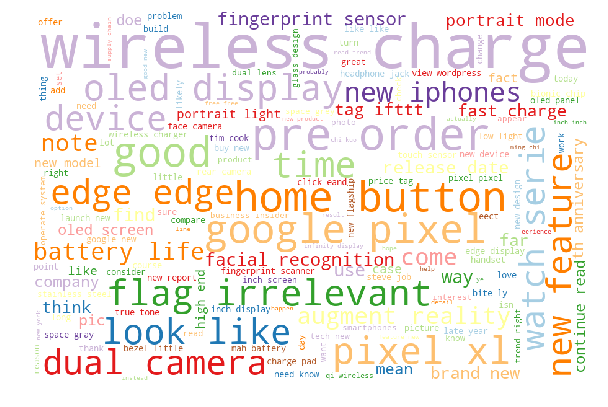

In [11]:
#Word cloud
plt.figure(figsize = (10,10))
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=iphone_stopwords,
                          colormap = 'Paired',
                          max_words=150,
                          max_font_size=100, 
                          width=900, 
                          height=600,
                          random_state=42
                         ).generate(iphone)
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("iphone_word1.png", dpi=900)

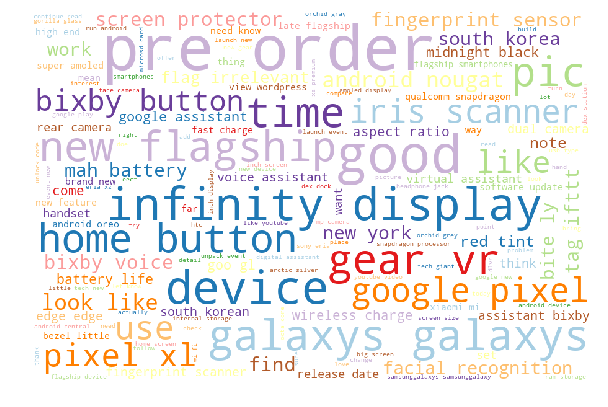

In [12]:
plt.figure(figsize = (10,10))
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=galaxy_stopwords,
                          colormap = 'Paired',
                          max_words=150,
                          max_font_size=100,
                          width=900, 
                          height=600,
                          random_state=42
                         ).generate(galaxy)
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()
fig.savefig("galaxy_word1.png", dpi=900)


## Top n words

In [49]:
iphone = nlp_data.loc[nlp_data['product'] == 'iPhone']
galaxy = nlp_data.loc[nlp_data['product'] == 'Galaxy']

In [50]:
from collections import Counter
histogram = Counter()
for row in iphone['clean']:
    for word in row:
        if word not in iphone_stopwords:
            histogram[word] += 1

In [51]:
iphone_sorted_lemma_count_pairs = sorted(histogram.items(),
                                  reverse=True,
                                  key=itemgetter(1))

Text(0, 0.5, 'Raw count')

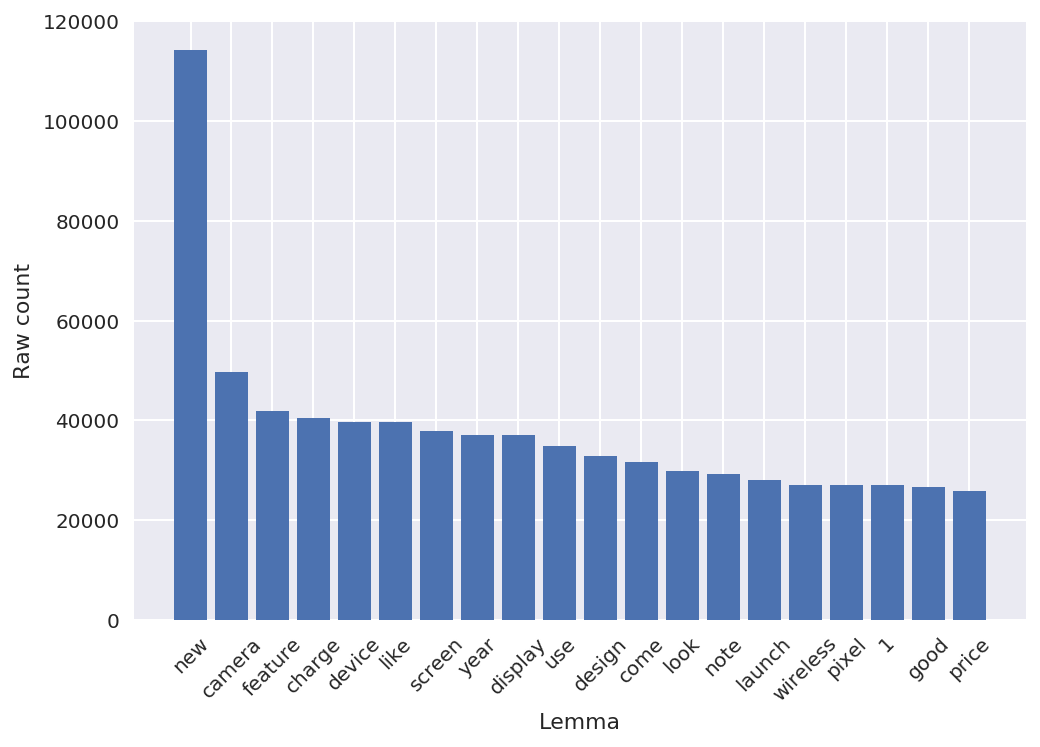

In [52]:
plt.style.use('seaborn')  
%config InlineBackend.figure_format = 'retina' 

num_top_lemmas_to_plot = 20
top_lemmas = [lemma for lemma, count in iphone_sorted_lemma_count_pairs[:num_top_lemmas_to_plot]]
top_counts = [count for lemma, count in iphone_sorted_lemma_count_pairs[:num_top_lemmas_to_plot]]
plt.bar(range(num_top_lemmas_to_plot), top_counts)
plt.xticks(range(num_top_lemmas_to_plot), top_lemmas, rotation=45)
plt.xlabel('Lemma')
plt.ylabel('Raw count')

In [53]:
histogram = Counter()
for row in galaxy['clean']:
    for word in row:
        if word not in iphone_stopwords:
            histogram[word] += 1

In [54]:
galaxy_sorted_lemma_count_pairs = sorted(histogram.items(),
                                  reverse=True,
                                  key=itemgetter(1))

Text(0, 0.5, 'Raw count')

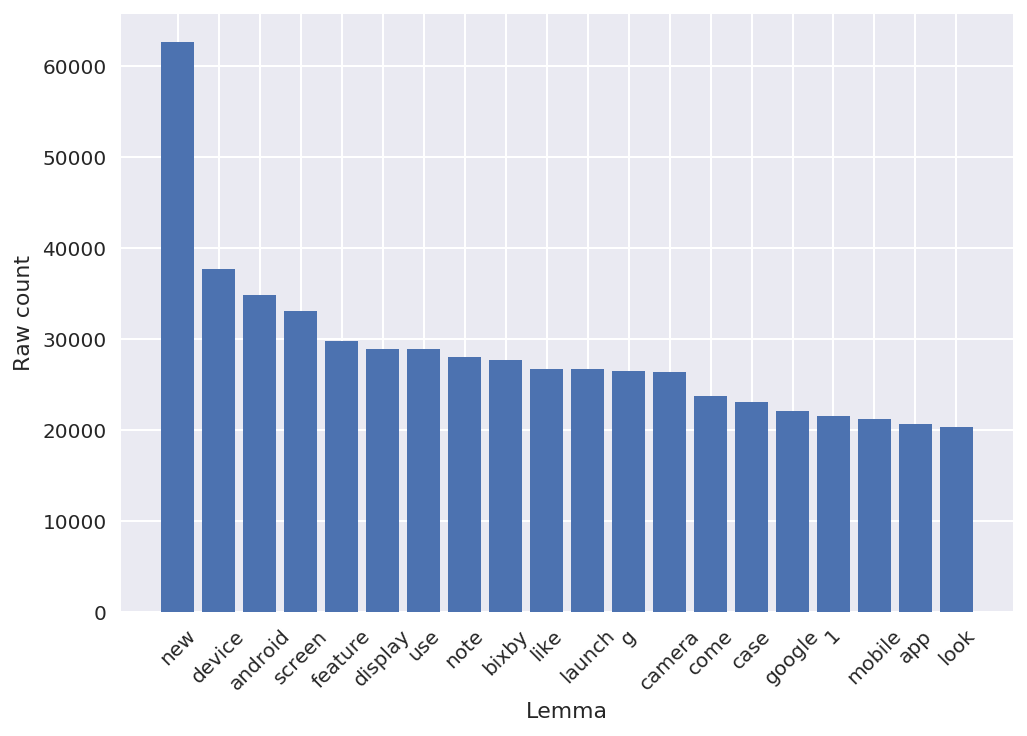

In [55]:
plt.style.use('seaborn')  
%config InlineBackend.figure_format = 'retina' 

num_top_lemmas_to_plot = 20
top_lemmas = [lemma for lemma, count in galaxy_sorted_lemma_count_pairs[:num_top_lemmas_to_plot]]
top_counts = [count for lemma, count in galaxy_sorted_lemma_count_pairs[:num_top_lemmas_to_plot]]
plt.bar(range(num_top_lemmas_to_plot), top_counts)
plt.xticks(range(num_top_lemmas_to_plot), top_lemmas, rotation=45)
plt.xlabel('Lemma')
plt.ylabel('Raw count')

## Topic modeling

In [42]:
vocab_size = 10000
# CountVectorizer does tokenization and can remove terms that occur too frequently, not frequently enough, or that are stop words

# document frequency (df) means number of documents a word appears in
tf_vectorizer_lemma = CountVectorizer(max_df=0.95,
                                min_df=2,
                                max_features=vocab_size,
                                stop_words='english')
tf_vectorizer_gal_lemma = CountVectorizer(max_df=0.95,
                                min_df=2,
                                max_features=vocab_size,
                                stop_words='english')

In [43]:
iphone_lemma = nlp_data.loc[nlp_data['product'] == 'iPhone']['clean']

In [44]:
galaxy_lemma = nlp_data.loc[nlp_data['product'] == 'Galaxy']['clean']

In [45]:
iphone_text_lemma = [' '.join(i) for i in iphone_lemma]

In [46]:
galaxy_text_lemma = [' '.join(i) for i in galaxy_lemma]

In [47]:
tf_iphone_lemma = tf_vectorizer_lemma.fit_transform(iphone_text_lemma)

In [48]:
tf_galaxy_lemma = tf_vectorizer_gal_lemma.fit_transform(galaxy_text_lemma)

In [50]:
num_topics = 10

lda_iphone_lemma = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=0)
lda_iphone_lemma.fit(tf_iphone_lemma)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [152]:
lda_galaxy_lemma = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=0)
lda_galaxy_lemma.fit(tf_galaxy_lemma)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

## Using grid search to pick best lda model

In [208]:
# Define Search Param
search_params = {'n_components': [8,9,10]}
# Init the Model
lda_iphone_lemma = LatentDirichletAllocation(max_iter=5, learning_method='online',random_state=0)
# Init Grid Search Class
model_iphone_lemma = GridSearchCV(lda_iphone_lemma, param_grid=search_params)
# Do the Grid Search
model_iphone_lemma.fit(tf_iphone_lemma)
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=256, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [8,9,10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=False)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=256, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [8, 9, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=False)

In [213]:
best_lda_model_iphone = model_iphone_lemma.best_estimator_
print("Best Model's Params: ", model_iphone_lemma.best_params_)
print("Best Log Likelihood Score: ", model_iphone_lemma.best_score_)
print("Model Perplexity: ", best_lda_model_iphone.perplexity(tf_iphone_lemma))

Best Model's Params:  {'n_components': 9}
Best Log Likelihood Score:  -17113927.976917733
Model Perplexity:  1216.3840656029001


In [211]:
best_lda_model_iphone

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_components=9, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [215]:
# Init the Model
lda_galaxy_lemma = LatentDirichletAllocation(max_iter=5, learning_method='online',random_state=0)
# Init Grid Search Class
model_galaxy_lemma = GridSearchCV(lda_galaxy_lemma, param_grid=search_params)
# Do the Grid Search
model_galaxy_lemma.fit(tf_galaxy_lemma)
GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=256, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [8,9,10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=False)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=256, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [8, 9, 10]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=False)

In [216]:
best_lda_model_galaxy = model_iphone_lemma.best_estimator_
print("Best Model's Params: ", model_iphone_lemma.best_params_)
print("Best Log Likelihood Score: ", model_iphone_lemma.best_score_)
print("Model Perplexity: ", best_lda_model_galaxy.perplexity(tf_galaxy_lemma))

Best Model's Params:  {'n_components': 9}
Best Log Likelihood Score:  -17113927.976917733
Model Perplexity:  50115.33537028912


In [219]:
topic_word_dist_iphone_lemma = np.array([topic_word_pseudocounts / np.sum(topic_word_pseudocounts)
                                     for topic_word_pseudocounts in best_lda_model_iphone.components_])

In [220]:
topic_word_dist_galaxy_lemma = np.array([topic_word_pseudocounts / np.sum(topic_word_pseudocounts)
                                     for topic_word_pseudocounts in best_lda_model_galaxy.components_])

In [221]:
num_top_words = 20

print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
print()

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(topic_word_dist_iphone_lemma[topic_idx])[::-1]
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print(tf_vectorizer_lemma.get_feature_names()[word_idx], ':', topic_word_dist_iphone_lemma[topic_idx, word_idx])
    print()

Displaying the top 20 words per topic and their probabilities within the topic...

[Topic 0]
phone : 0.02315820115416436
screen : 0.016544849859725645
new : 0.015210956254454377
like : 0.013618793013620697
design : 0.012765399132305854
look : 0.012458297357092234
glass : 0.010021675841381226
good : 0.009998256495132918
feature : 0.009961940176598655
use : 0.009666363005797679
apple : 0.009364230222317634
year : 0.008985059129799309
pron : 0.00830647780415292
little : 0.008168861051544764
display : 0.007675245270048312
edge : 0.007627661415997717
button : 0.0074985294187629725
touch : 0.007219664836477211
time : 0.006891750019939072
know : 0.006495516111517191

[Topic 1]
plus : 0.12281431500935724
gb : 0.08273441796795535
apple : 0.04562669840722133
new : 0.02893258903750179
gold : 0.025146902460705632
unlock : 0.024648350529064583
light : 0.022605059108767846
portrait : 0.02029907232970312
silver : 0.016994335386404748
space : 0.01616146518565248
color : 0.013207553585550171
black : 0.

IndexError: index 9 is out of bounds for axis 0 with size 9

In [222]:
num_top_words = 20

print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
print()

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(topic_word_dist_galaxy_lemma[topic_idx])[::-1]
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print(tf_vectorizer_gal_lemma.get_feature_names()[word_idx], ':', topic_word_dist_galaxy_lemma[topic_idx, word_idx])
    print()

Displaying the top 20 words per topic and their probabilities within the topic...

[Topic 0]
podcast : 0.02315820115416436
ses : 0.016544849859725645
nuovo : 0.015210956254454377
mac : 0.013618793013620697
designate : 0.012765399132305854
marc : 0.012458297357092234
gizmoslip : 0.010021675841381226
golf : 0.009998256495132918
feel : 0.009961940176598655
uzkaxaa : 0.009666363005797679
anxiety : 0.009364230222317634
yelp : 0.008985059129799309
quickly : 0.00830647780415292
mal : 0.008168861051544764
distinction : 0.007675245270048312
eed : 0.007627661415997717
bust : 0.0074985294187629725
transistor : 0.007219664836477211
toll : 0.006891750019939072
les : 0.006495516111517191

[Topic 1]
praise : 0.12281431500935724
gbp : 0.08273441796795535
anxiety : 0.04562669840722133
nuovo : 0.02893258903750179
goggle : 0.025146902460705632
unsolicited : 0.024648350529064583
lxiful : 0.022605059108767846
priority : 0.02029907232970312
slot : 0.016994335386404748
spinner : 0.01616146518565248
collabora

IndexError: index 9 is out of bounds for axis 0 with size 9

### Dominant topic for each post

In [223]:
# Dominant topics 
lda_output_iphone = best_lda_model_iphone.transform(tf_iphone_lemma)
lda_output_galaxy = best_lda_model_galaxy.transform(tf_galaxy_lemma)

In [226]:
topicnames_iphone = ['Topic' + str(i) for i in range( best_lda_model_iphone.n_components)]
postnames_iphone = [str(i) for i in range(len(iphone_lemma))]

In [227]:
topicnames_gal = ['Topic' + str(i) for i in range(best_lda_model_galaxy.n_components)]
postnames_gal = [str(i) for i in range(len(galaxy_lemma))]

In [232]:
# Make the pandas dataframe
df_post_topic_iphone_lemma = pd.DataFrame(np.round(lda_output_iphone, 2), columns=topicnames_iphone, index=postnames)

In [234]:
df_post_topic_galaxy_lemma = pd.DataFrame(np.round(lda_output_galaxy, 2), columns=topicnames_gal, index=postnames_gal)

In [235]:
dominant_topic_iphone_lemma = np.argmax(df_post_topic_iphone_lemma.values, axis=1)
df_post_topic_iphone_lemma['dominant_topic'] = dominant_topic_iphone_lemma

In [236]:
dominant_topic_galaxy_lemma = np.argmax(df_post_topic_galaxy_lemma.values, axis=1)
df_post_topic_galaxy_lemma['dominant_topic'] = dominant_topic_galaxy_lemma

In [237]:
# Styling
def color_green(val):
    color = 'red' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)
def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)
# Apply Style
df_post_topic_iphone_lemma_style = df_post_topic_iphone_lemma.head(15).style.applymap(color_green).applymap(make_bold)
df_post_topic_iphone_lemma_style

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,dominant_topic
0,0.11,0,0.14,0.12,0,0.1,0,0,0.52,8
1,0.37,0.14,0.25,0,0.17,0,0,0,0.07,0
2,0,0.64,0,0,0.07,0,0.26,0,0,1
3,0.11,0.43,0.13,0.01,0.01,0.1,0.01,0.21,0.01,1
4,0.02,0.82,0.02,0.02,0.02,0.02,0.02,0.02,0.02,1
5,0.21,0,0.03,0,0.09,0.25,0,0,0.42,8
6,0.13,0,0.19,0,0.25,0,0.12,0.13,0.17,4
7,0.46,0.08,0.11,0,0,0,0.21,0,0.13,0
8,0.01,0.01,0.46,0.01,0.01,0.49,0.01,0.01,0.01,5
9,0.04,0,0,0,0.58,0,0,0.35,0.02,4


In [238]:
df_post_topic_galaxy_lemma_style = df_post_topic_galaxy_lemma.head(15).style.applymap(color_green).applymap(make_bold)
df_post_topic_galaxy_lemma_style

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,dominant_topic
0,0.19,0.07,0.16,0.08,0.06,0.13,0.1,0.05,0.16,0
1,0.26,0.01,0.37,0.08,0.01,0.01,0.01,0.15,0.11,2
2,0.31,0.03,0.2,0.04,0.04,0.14,0.08,0.04,0.13,0
3,0.11,0.1,0.25,0.05,0.11,0.1,0.17,0.06,0.05,2
4,0.56,0.01,0.21,0.18,0.01,0.01,0.01,0.01,0.01,0
5,0,0.04,0.22,0.23,0,0.22,0.05,0.06,0.18,3
6,0.31,0.03,0.2,0.04,0.04,0.14,0.08,0.04,0.13,0
7,0.14,0.04,0.07,0.09,0.11,0.15,0.17,0.06,0.16,6
8,0.19,0.11,0.1,0.07,0.1,0.13,0.12,0.09,0.08,0
9,0.11,0.01,0.15,0.16,0.06,0.06,0.01,0.01,0.45,8


In [239]:
def topic_sample_post(topic_num, topic_matrix_df, raw_text_df):
    topic_df = topic_matrix_df.loc[topic_matrix_df['dominant_topic'] == topic_num]
    topic = 'Topic'+str(topic_num)
    index = topic_df.nlargest(5, topic).index.tolist()
    sample_post = [raw_text_df[int(i)] for i in index]
    return sample_post

## Topic word cloud

In [240]:
# word cloud for each topic
def topic_word_cloud(topic_num, topic_matrix_df, lemma_df):
    topic_df = topic_matrix_df.loc[topic_matrix_df['dominant_topic'] == topic_num]
    text = [lemma_df[int(i)] for i in topic_df.index.tolist()]
    text = [word for sentence in text for word in sentence.split(' ')]
    text = ' '.join(text)
    return text

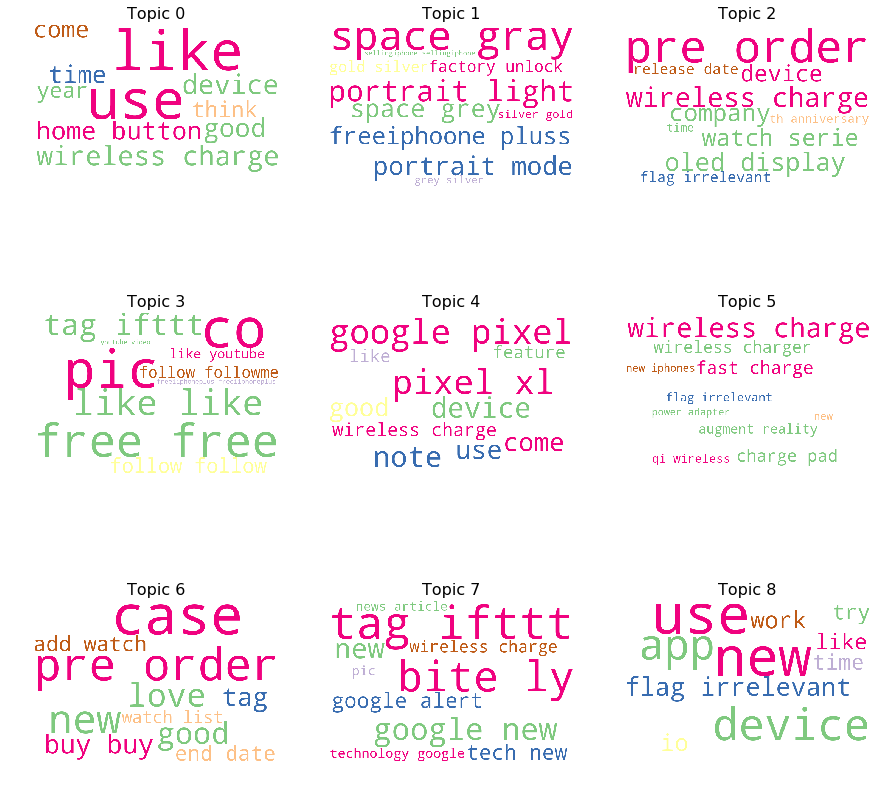

In [282]:
fig, axes = plt.subplots(3, 3, figsize=(15,15), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    text = topic_word_cloud(i,df_post_topic_iphone_lemma, iphone_text_lemma)   
    wordcloud = WordCloud(
                          background_color='white',
                          stopwords=iphone_stopwords,
                          colormap = 'Accent',
                          max_words=10,
                          max_font_size=200,
                          width=900, 
                          height=600,
                          random_state=42
                         ).generate(text)
    plt.gca().imshow(wordcloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

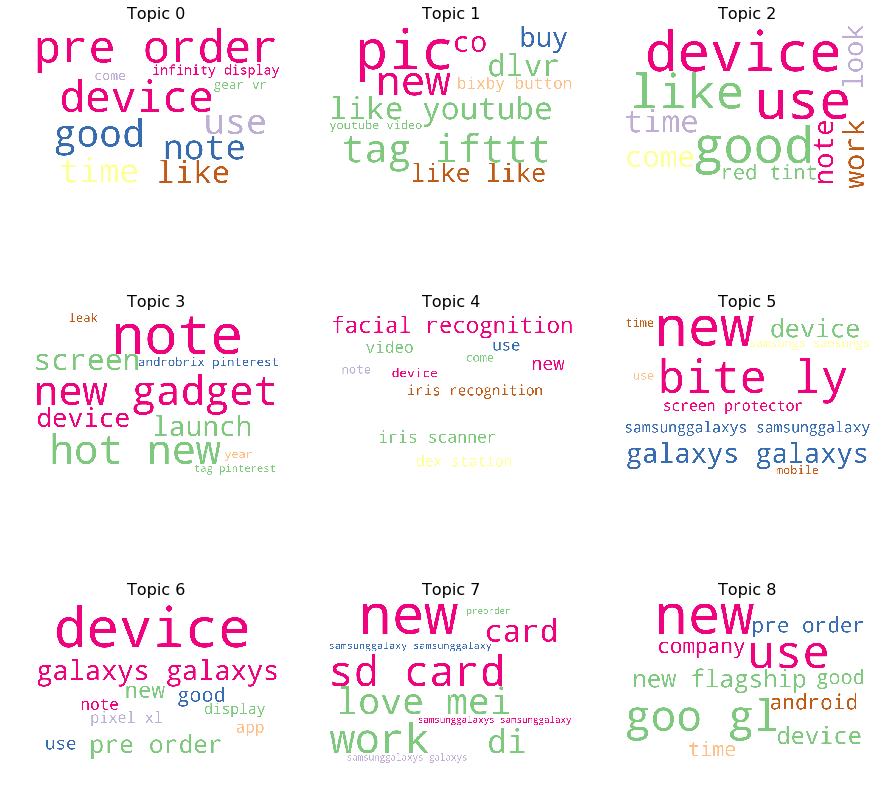

In [283]:
fig, axes = plt.subplots(3, 3, figsize=(15,15), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    text = topic_word_cloud(i,df_post_topic_galaxy_lemma, galaxy_text_lemma)   
    wordcloud = WordCloud(
                          background_color='white',
                          stopwords=iphone_stopwords,
                          colormap = 'Accent',
                          max_words=10,
                          max_font_size=200,
                          width=900, 
                          height=600,
                          random_state=42
                         ).generate(text)
    plt.gca().imshow(wordcloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

### Create keywords network graph

In [295]:
vocab_size = 25
# CountVectorizer does tokenization and can remove terms that occur too frequently, not frequently enough, or that are stop words

# document frequency (df) means number of documents a word appears in
tf_vectorizer_lemma_net = CountVectorizer(max_df=0.9,
                                min_df=2,
                                max_features=vocab_size,
                                stop_words=iphone_stopwords)
tf_vectorizer_gal_lemma_net = CountVectorizer(max_df=0.9,
                                min_df=2,
                                max_features=vocab_size,
                                stop_words=galaxy_stopwords)

In [296]:
iphone_lemma = nlp_data.loc[nlp_data['product'] == 'iPhone']['clean']

In [297]:
galaxy_lemma = nlp_data.loc[nlp_data['product'] == 'Galaxy']['clean']

In [298]:
tf_iphone_lemma_net = tf_vectorizer_lemma_net.fit_transform(iphone_text_lemma)

In [299]:
tf_galaxy_lemma_net = tf_vectorizer_gal_lemma_net.fit_transform(galaxy_text_lemma)

In [300]:
tf_iphonec_lemma = tf_iphone_lemma_net.T * tf_iphone_lemma_net

In [301]:
tf_iphonec_lemma.setdiag(0)

In [385]:
names = tf_vectorizer_lemma_net.get_feature_names()
mapping = {i:names[i] for i in range(len(names))}
G=nx.from_scipy_sparse_matrix(tf_iphonec_lemma)
H = nx.relabel_nodes(G, mapping)

In [386]:
edges = H.edges()
weights = [H[u][v]['weight'] for u,v in edges]
weights = [i/40000 for i in weights]

In [387]:
degree = dict(H.degree)

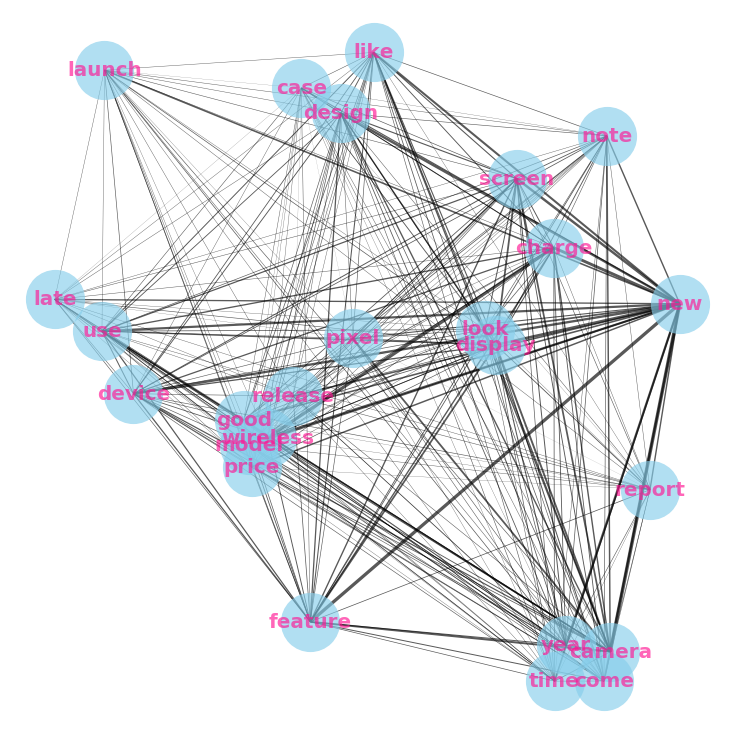

In [403]:
plt.figure(figsize = (10,10))
options = {
    'node_color': "skyblue",
    'node_size': 3500,
    'alpha' : 0.65,
    'line_color': 'grey',
    'linewidths': 0,
    'font_weight':'bold',
    'font_color':'deeppink',
    'font_size':20
}
nx.draw(H, with_labels=True, **options,width = weights)

In [312]:
tf_galaxyc_lemma = tf_galaxy_lemma_net.T * tf_galaxy_lemma_net

In [313]:
tf_galaxyc_lemma.setdiag(0)

In [404]:
names = tf_vectorizer_gal_lemma_net.get_feature_names()
mapping = {i:names[i] for i in range(len(names))}
G=nx.from_scipy_sparse_matrix(tf_galaxyc_lemma)
H = nx.relabel_nodes(G, mapping)

In [405]:
edges = H.edges()
weights = [H[u][v]['weight'] for u,v in edges]
weights = [i/40000 for i in weights]

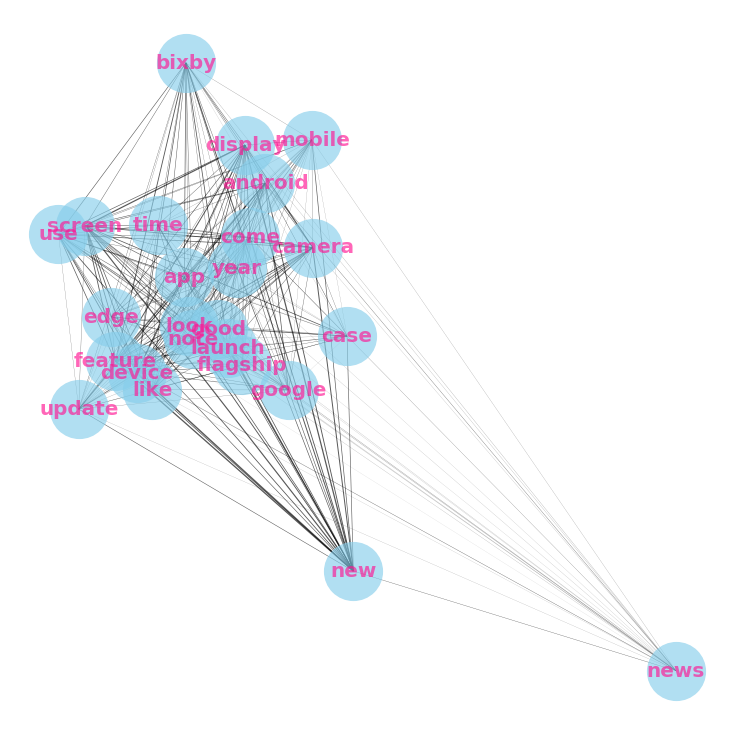

In [421]:
plt.figure(figsize = (10,10))
options = {
    'node_color': "skyblue",
    'node_size': 3500,
    'alpha' : 0.65,
    'line_color': 'grey',
    'linewidths': 0,
    'font_weight':'bold',
    'font_color':'deeppink',
    'font_size':20
}
nx.draw(H, with_labels=True, **options, width = weights)